In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
df=pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
df = df.drop([1,2,3,4], axis=1)
df.columns=['sentiment','text']
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


<BarContainer object of 2 artists>

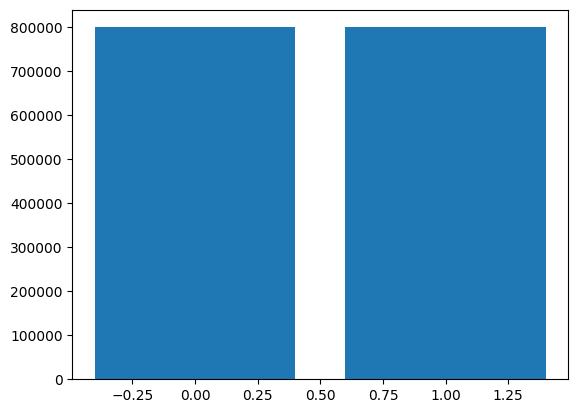

In [4]:
df['sentiment']=df['sentiment'].replace(4,1)
import matplotlib.pyplot as plt
plt.bar(df.sentiment.value_counts().index,df.sentiment.value_counts().values)

# **DATA PREPROCESSING AND VISUALISATION**

In [5]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import re
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [7]:
def process(text):
    text=re.sub(text_cleaning_re,' ',str(text).lower()).strip()
    tokens=[]
    for i in text.split():
        if i not in stop_words:
            tokens.append(stemmer.stem(i))
    return ' '.join(tokens)
   

In [8]:
df['text']=df['text'].map(lambda x:process(x))
df.head()

,sentiment,text
0,0,awww bummer shoulda got david carr third day
1,0,upset updat facebook text might cri result sch...
2,0,dive mani time ball manag save 50 rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav mad see


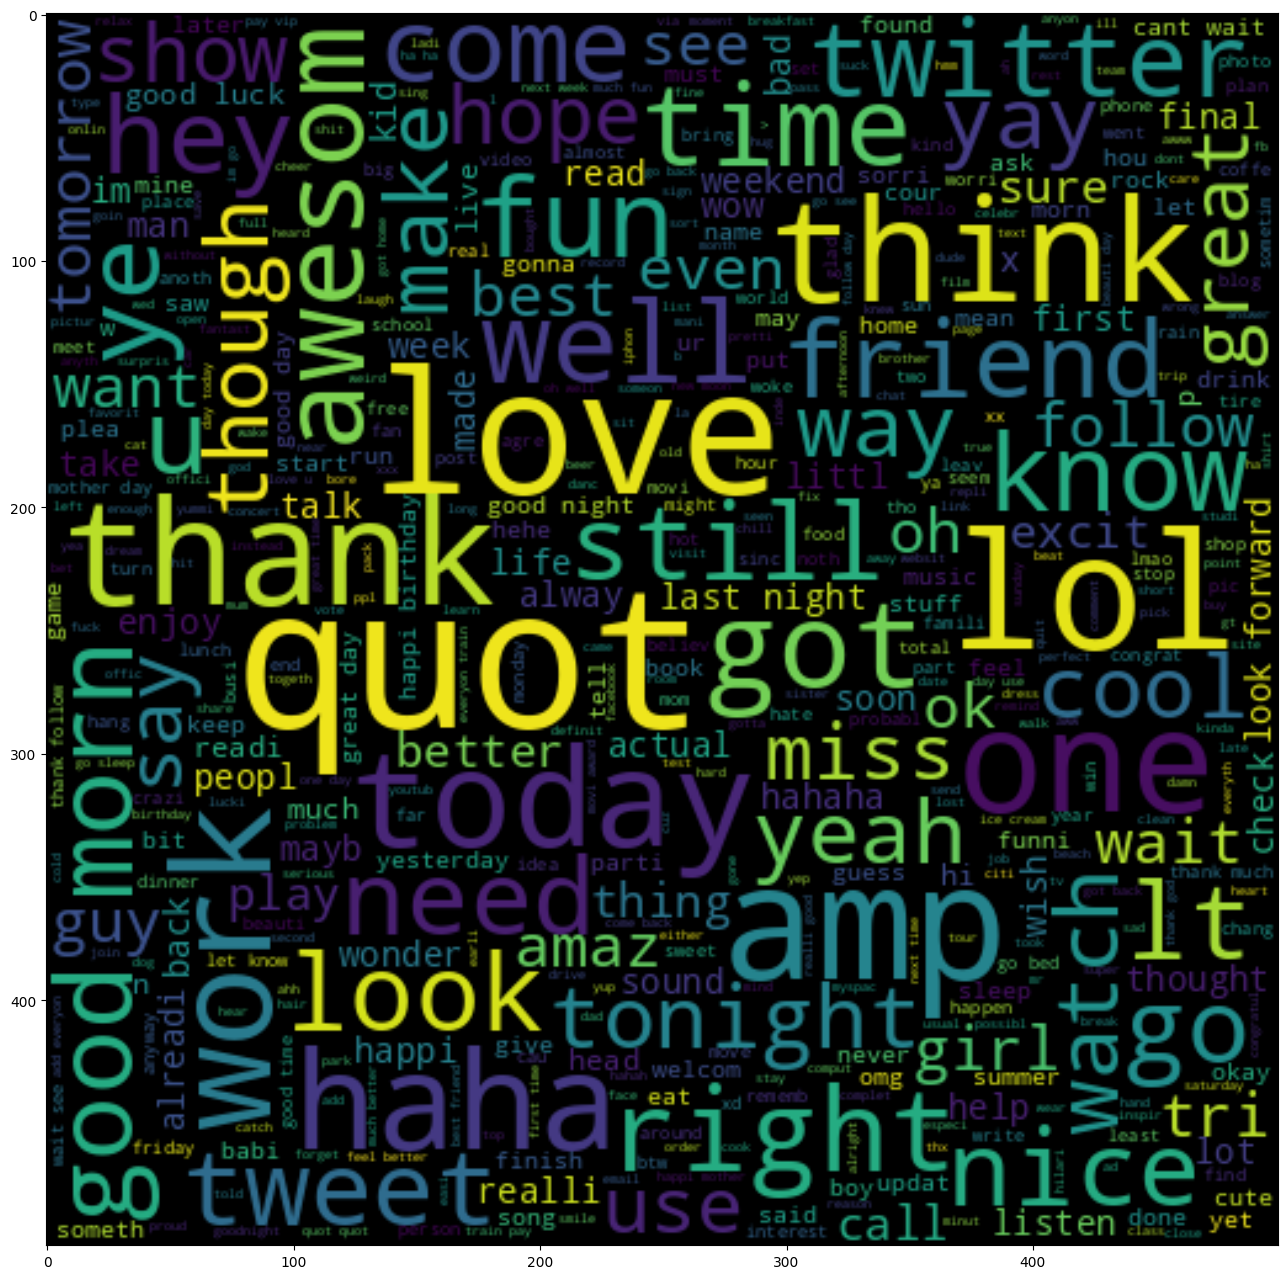

In [9]:
#frequent words
from  wordcloud import WordCloud 
plt.figure(figsize=(16,16))
wc=WordCloud(max_words=2000,width=500,height=500,max_font_size=80).generate(' '.join(df[df['sentiment']==1].text))
plt.imshow(wc,interpolation='bilinear')



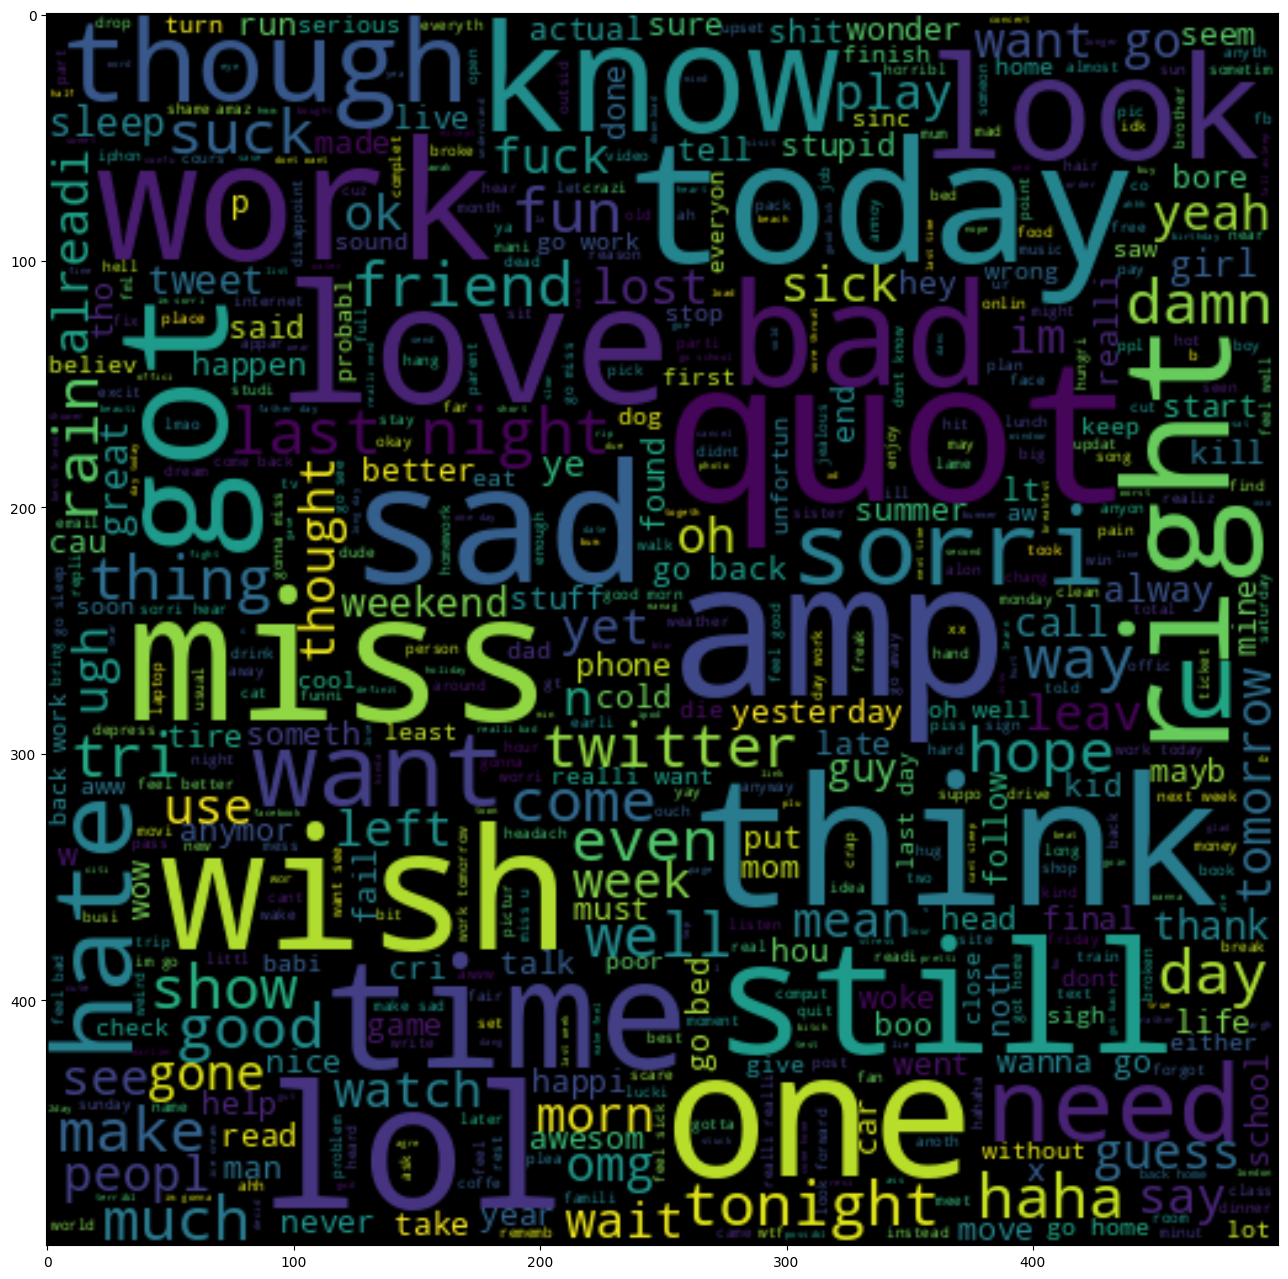

In [10]:
plt.figure(figsize=(16,16))
wc=WordCloud(max_words=2000,width=500,height=500,max_font_size=80).generate(' '.join(df[df['sentiment']==0].text))
plt.imshow(wc,interpolation='bilinear')


# **deep learning approach (biLSTM)**

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_data,test_data=train_test_split(df,train_size=0.8,test_size=0.2,random_state=71)


In [12]:
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index #creates index for each word
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 248713


In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train=pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen=30) #makes eack array of same length by adding 0 if len<30
x_test=pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen=30)

y_train=train_data.sentiment.to_numpy()
y_test=test_data.sentiment.to_numpy()
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

print(x_train.shape,y_train.shape)

(1280000, 30) (1280000, 1)


In [14]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-01-03 19:41:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-01-03 19:41:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-03 19:41:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [15]:
GLOVE_EMB='/kaggle/working/glove.6B.300d.txt'
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split() #line contains word at 0 followed by 300 embedding values
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [16]:
word_index.__len__()

248712

In [17]:
EMBEDDING_DIM=300
embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=30,
                                          trainable=False)

In [18]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#model architecture #1
sequence_input = Input(shape=(30, dtype='int32'))
emb_layer=embedding_layer(sequence_input)
x=Bidirectional(LSTM(64,dropout=0.2, recurrent_dropout=0.2))(emb_layer)
x=Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
x=Dense(1,activation='sigmoid')(x)

In [56]:
#model architecture
sequence_input = Input(shape=(30,))
emb_layer=embedding_layer(sequence_input)
x=Bidirectional(LSTM(64,dropout=0.2, recurrent_dropout=0.2))(emb_layer)
x=Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
output=Dense(1,activation='sigmoid')(x)
model= tf.keras.Model(sequence_input,output)

In [57]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           74613900  
                                                                 
 bidirectional (Bidirection  (None, 128)               186880    
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                             

In [59]:
lstm_history=model.fit(x_train,y_train,batch_size=512,epochs=5,validation_split=0.2)

Epoch 1/5
2000/2000 [==============================] - 186s 93ms/step - loss: 0.5038 - accuracy: 0.7506 - val_loss: 0.4901 - val_accuracy: 0.7600
Epoch 2/5
2000/2000 [==============================] - 185s 92ms/step - loss: 0.4898 - accuracy: 0.7603 - val_loss: 0.4857 - val_accuracy: 0.7612
Epoch 3/5
2000/2000 [==============================] - 186s 93ms/step - loss: 0.4827 - accuracy: 0.7648 - val_loss: 0.4898 - val_accuracy: 0.7653
Epoch 4/5
2000/2000 [==============================] - 186s 93ms/step - loss: 0.4780 - accuracy: 0.7679 - val_loss: 0.4814 - val_accuracy: 0.7650
Epoch 5/5
2000/2000 [==============================] - 185s 93ms/step - loss: 0.4747 - accuracy: 0.7703 - val_loss: 0.4815 - val_accuracy: 0.7670


In [62]:
lstm_history=model.fit(x_train,y_train,batch_size=512,epochs=8,validation_split=0.2)
model.save('/kaggle/working/model_lstm/lstm.keras')
score=model.evaluate(x_test,y_test,verbose=1)

Epoch 1/8
2000/2000 [==============================] - 187s 93ms/step - loss: 0.4722 - accuracy: 0.7713 - val_loss: 0.4864 - val_accuracy: 0.7662
Epoch 2/8
2000/2000 [==============================] - 186s 93ms/step - loss: 0.4702 - accuracy: 0.7725 - val_loss: 0.4861 - val_accuracy: 0.7671
Epoch 3/8
2000/2000 [==============================] - 186s 93ms/step - loss: 0.4686 - accuracy: 0.7734 - val_loss: 0.4779 - val_accuracy: 0.7683
Epoch 4/8
2000/2000 [==============================] - 185s 93ms/step - loss: 0.4676 - accuracy: 0.7747 - val_loss: 0.4788 - val_accuracy: 0.7679
Epoch 5/8
2000/2000 [==============================] - 185s 93ms/step - loss: 0.4664 - accuracy: 0.7747 - val_loss: 0.4812 - val_accuracy: 0.7677
Epoch 6/8
2000/2000 [==============================] - 186s 93ms/step - loss: 0.4653 - accuracy: 0.7753 - val_loss: 0.4825 - val_accuracy: 0.7677
Epoch 7/8
2000/2000 [==============================] - 186s 93ms/step - loss: 0.4650 - accuracy: 0.7757 - val_loss: 0.4785 -

In [61]:
print(score[0],score[1])

0.4791107475757599 0.767856240272522


# **DEEP LEARNING #2**

In [20]:
#model architecture #2
sequence_input = Input(shape=(30,))
emb_layer=embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(emb_layer)
x=Dense(512,activation='relu')(x)
x=LSTM(128,dropout=0.2, recurrent_dropout=0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [21]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           74613900  
                                                                 
 spatial_dropout1d (Spatial  (None, 30, 300)           0         
 Dropout1D)                                                      
                                                                 
 dense (Dense)               (None, 30, 512)           154112    
                                                                 
 lstm (LSTM)                 (None, 128)               328192    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                             

In [22]:
history=model.fit(x_train,y_train,batch_size=1024,epochs=10,validation_split=0.2)

Epoch 1/10
1000/1000 [==============================] - 81s 71ms/step - loss: 0.5199 - accuracy: 0.7381 - val_loss: 0.5155 - val_accuracy: 0.7583
Epoch 2/10
1000/1000 [==============================] - 71s 71ms/step - loss: 0.4943 - accuracy: 0.7567 - val_loss: 0.5128 - val_accuracy: 0.7626
Epoch 3/10
1000/1000 [==============================] - 71s 71ms/step - loss: 0.4871 - accuracy: 0.7607 - val_loss: 0.5052 - val_accuracy: 0.7653
Epoch 4/10
1000/1000 [==============================] - 71s 71ms/step - loss: 0.4821 - accuracy: 0.7641 - val_loss: 0.5090 - val_accuracy: 0.7653
Epoch 5/10
1000/1000 [==============================] - 71s 71ms/step - loss: 0.4787 - accuracy: 0.7659 - val_loss: 0.5034 - val_accuracy: 0.7662
Epoch 6/10
1000/1000 [==============================] - 71s 71ms/step - loss: 0.4760 - accuracy: 0.7681 - val_loss: 0.5012 - val_accuracy: 0.7683
Epoch 7/10
1000/1000 [==============================] - 72s 72ms/step - loss: 0.4739 - accuracy: 0.7695 - val_loss: 0.5007 -

In [25]:
history=model.fit(x_train,y_train,batch_size=1024,epochs=5,validation_split=0.2)
score = model.evaluate(x_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

10000/10000 [==============================] - 111s 11ms/step - loss: 0.4982 - accuracy: 0.7697
Test Score: 0.49824273586273193
Test Accuracy: 0.7696874737739563


KeyError: 'acc'

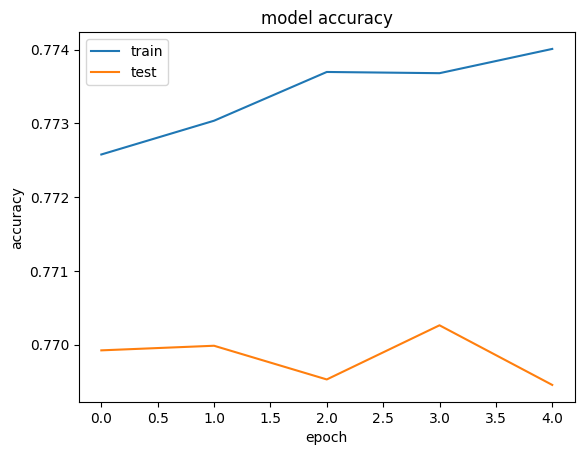

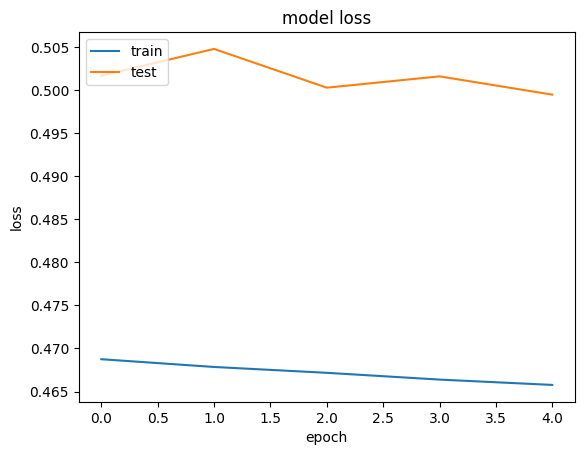

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

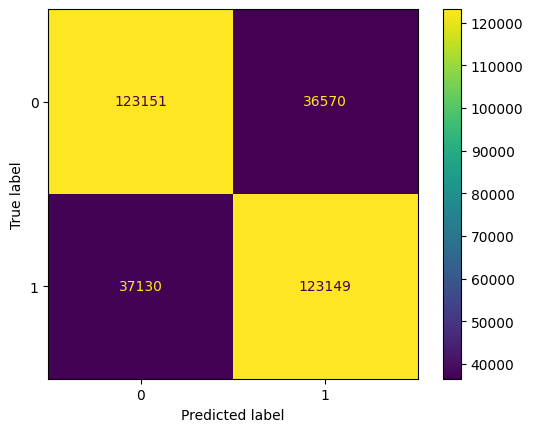

In [32]:
#pred=model.predict(x_test,verbose=1,batch_size=10000)
def decode_sentiment(score):
    return 1 if score>0.5 else 0
y_pred = [decode_sentiment(preds) for preds in pred]
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# **machine learning approach(LOGISTIC REGRESSION)**

In [33]:
data=df.copy()
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000)
bow = bow_vectorizer.fit_transform(data['text'])

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

x_train,x_test,y_train,y_test=train_test_split(bow,data['sentiment'],test_size=0.2,random_state=88)
model = LogisticRegression(max_iter=600)
model.fit(x_train, y_train)

LogisticRegression(max_iter=600)

In [35]:
pred = model.predict(x_test)
f1=f1_score(y_test, pred)
acc=accuracy_score(y_test,pred)
print(f1,acc)

0.7577850725846621 0.74774375


# **ML approach #2 (SVM)**


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

data=df.copy()
vec=TfidfVectorizer()
vectors=vec.fit_transform(data['text'])
x_train,x_test,y_train,y_test=train_test_split(vectors,data['sentiment'],test_size=0.2,random_state=80)
x_test

<320000x288396 sparse matrix of type '<class 'numpy.float64'>'
	with 2178361 stored elements in Compressed Sparse Row format>

In [12]:
from sklearn.svm import LinearSVC
model = LinearSVC()
model.fit(x_train, y_train)
pred=model.predict(x_test)

In [14]:
f1=f1_score(y_test, pred)
acc=accuracy_score(y_test,pred)
print(f1,acc)

0.7719210163783867 0.76718125


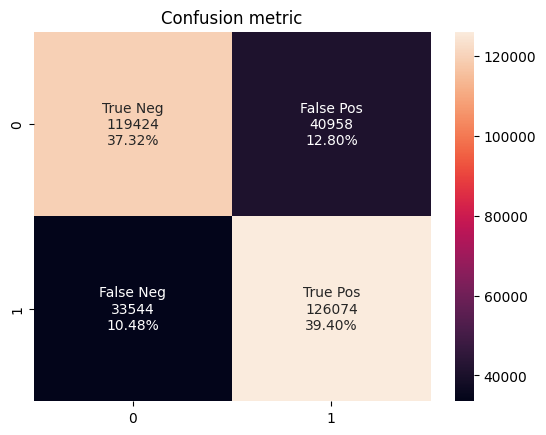

[Text(4.444444444444452, 0.5, 'True labels'),
 Text(0.5, 4.444444444444445, 'Predicted labels')]

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
cf_matrix = confusion_matrix(y_test, pred)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
s = sns.heatmap(cf_matrix, annot=labels,fmt='')
s.set_title("Confusion metric")
plt.show()
s.set(ylabel='True labels', xlabel='Predicted labels')